In [68]:
import torch
import h5py
import matplotlib.pyplot as plt

import common
from core import *

In [69]:
data = h5py.File("data/out_poisson/poisson.h5")

geometry = torch.tensor(data["/Mesh/mesh/geometry"][...], dtype=torch.float32)
topology = torch.tensor(data["/Mesh/mesh/topology"][...], dtype=torch.int32)
func = torch.tensor(data["/Function/f/0"][...], dtype=torch.float64)

print(geometry.shape)
print(topology.shape)
print(func.shape)

torch.Size([81, 2])
torch.Size([128, 3])
torch.Size([81, 1])


In [84]:
def on_boundary(x):
    n = x.shape[0]
    return torch.isclose(x[:, 0], 0.0*torch.ones(n)) | \
           torch.isclose(x[:, 0], 1.0*torch.ones(n)) | \
           torch.isclose(x[:, 1], 0.0*torch.ones(n)) | \
           torch.isclose(x[:, 1], 1.0*torch.ones(n))

In [106]:
# get edges from topology
senders, receivers = common.topology_to_edges(topology) # two way connectivity implied
senders = senders.long()
receivers = receivers.long()

# compute mesh distances
senders_pos = geometry[senders]
receivers_pos = geometry[receivers]
mesh_distances = torch.sqrt((senders_pos[:, 0] - receivers_pos[:, 0])**2 + (senders_pos[:, 1] - receivers_pos[:, 1])**2)

# create edge set
edgeset = EdgeSet(senders, receivers, mesh_distances)

# create node features
node_types = F.one_hot(on_boundary(geometry).long())
node_features = torch.cat([func, node_types], dim=1)

# create graph
graph = MultiGraph(node_features, edgeset)

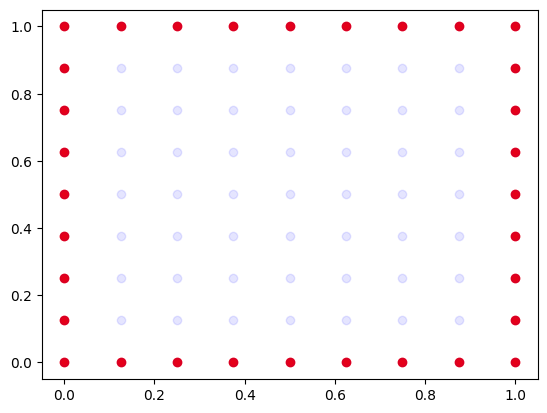

In [111]:
# visualise nodes with their types
x_b, y_b = torch.unbind(geometry[on_boundary(geometry)], dim=1)
x, y = torch.unbind(geometry, dim=1)
plt.scatter(x_b, y_b, c='r')
plt.scatter(x, y, c='b', alpha=0.1)
plt.show()